# 1) Input each green-ampt parameter

In [1]:
# Import
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
    
# Take inputs (hydraulic conductivity, suction head, initial moisture 
# content, porosity, storm intensity, storm duration, time step)
K = 0.05 # cm/hr
PSI = 29.22 # cm
THETAi = 0.1269
ETA = 0.423
i = 1 # cm/hr
D = 4 # hr
step = 0.25 #hr

# 2) Calculate Time to Ponding

In [2]:
# Calculate change in moisture content
DELTA_THETA = ETA - THETAi

# Calculate time to ponding
timeTOpond = K * PSI * DELTA_THETA / (i * (i - K)) # hr

# 3) Generate a before ponding dataframe

In [3]:
# Calculate cumulative infiltration depth before ponding
# Address if time to ponding is more than storm duration
if timeTOpond > D:
    timeBEFOREpond = D #hr
else:
    timeBEFOREpond = timeTOpond #hr
columns = ['t (hr)', 'F (cm)', 'f (cm/hr)']
dfBEFORE = pd.DataFrame(columns=columns)

# Loop through start time to time before ponding
for t in np.append(np.arange(0, timeBEFOREpond, step), timeBEFOREpond):
    # Calculate cumulative infiltraton 
    F = i * t #cm
    # Calculate infiltration rate 
    f = i #cm/hr
    # Add time, cumulative infiltration, and infiltration rate to to before 
    # ponding dataframe
    df = pd.DataFrame(np.array([[t, F, f]]),
                      columns=columns)
    dfBEFORE = pd.concat([dfBEFORE, df])

/tmp/ipykernel_40034/451695997.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfBEFORE = pd.concat([dfBEFORE, df])


# 4) Generate an after ponding dataframe

In [4]:
# If the storm duration is less than time to ponding return dataframe
if timeTOpond < D:
    # Calculate cumulative infilitration depth and infiltration rate after 
    # ponding
    # Generate an after ponding dataframe
    dfAFTER = pd.DataFrame(columns=columns)
    
    # Define Green Ampt Equation and derivative
    def g(F, t, K, PSI, DELTA_THETA):
        if PSI * DELTA_THETA == 0:
            print('PSI * DELTA_THETA cannot equal zero')
            sys.exit()
        g = F - K * t - PSI * DELTA_THETA * np.log(1 + F / (PSI * DELTA_THETA))
        return g
    def gPrime(F, PSI, DELTA_THETA):
        if F == 0:
            print('F cannot equal zero')
            sys.exit()
        gPrime = 1 - PSI * DELTA_THETA / (PSI * DELTA_THETA + F)
        return gPrime    
    
    # Loop through time to ponding to end of storm
    for t in np.arange(((timeBEFOREpond + step) // step) * step, D + step, 
                       step):
        # Solve using Newton's Method
        # Make intial guess
        Fguess = K * t #cm
        # Iterate 10 times
        for iteration in range(10):
            # Calculate new guess
            F = Fguess - g(Fguess, t, K, PSI, DELTA_THETA
                           ) / gPrime(Fguess, PSI, DELTA_THETA) #cm
            # Set guess as cumulative infilitration depth
            Fguess = F #cm
        # Calculate infiltration rate
        f = K * (PSI * DELTA_THETA / F + 1) #cm/hr
        # Add time, cumulative infiltration, and infiltration rate to after 
        # ponding data frame
        df = pd.DataFrame(np.array([[t, F, f]]),
                          columns=columns)
        dfAFTER = pd.concat([dfAFTER, df])
        
    # Combine the before and after ponding dataframes
    dfTOTAL = pd.concat([dfBEFORE, dfAFTER])   
else:
    dfTOTAL = dfBEFORE

/tmp/ipykernel_40034/2419986502.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfAFTER = pd.concat([dfAFTER, df])


# 5) Plot Results

Text(0, 0.5, 'Cumulative Infilitration Depth (F)(cm)')

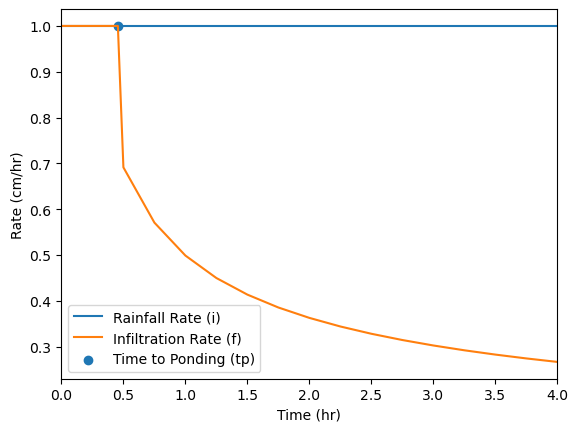

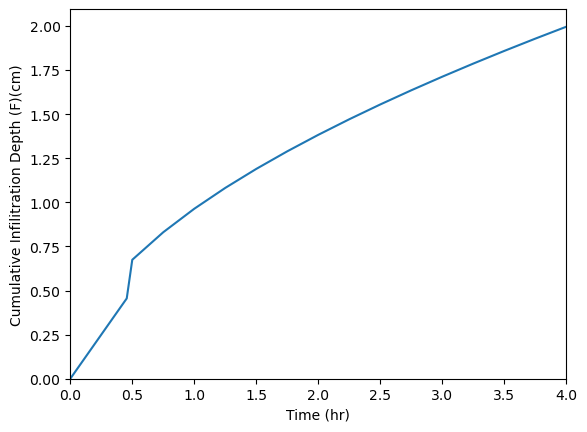

In [5]:
# Plot rate graph
fig, ax = plt.subplots()

# Plot rainfall rate
ax.plot([0, D], 
        [i, i],
        label='Rainfall Rate (i)')

# Plot infiltration rate
ax.plot(dfTOTAL['t (hr)'],
        dfTOTAL['f (cm/hr)'],
        label='Infiltration Rate (f)')

# Plot time to ponding
ax.scatter(timeTOpond,
           i,
           label='Time to Ponding (tp)')

# Adjust and label x axis
ax.set_xlim([0, D])
ax.set_xlabel('Time (hr)')

# Label y axis
ax.set_ylabel('Rate (cm/hr)')

# Legend
plt.legend()

# Plot depth graph
fig, ax = plt.subplots()

# Plot cumulative infiltration
ax.plot(dfTOTAL['t (hr)'],
         dfTOTAL['F (cm)'],
         label='Cumulative Infiltration (F)')

# Adjust and label x axis
ax.set_xlim([0, D])
ax.set_xlabel('Time (hr)')

# Label y axis 2
ax.set_ylim(bottom=0)
ax.set_ylabel('Cumulative Infilitration Depth (F)(cm)')